In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten, Conv2D

# Criando imagens aleatórias com retangulos e bounding boxes

In [70]:
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  #background = 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 1, 4))

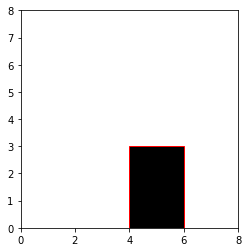

In [71]:
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

# Reshape and normalize média 0 std 1. 

In [72]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 64), -4.2503778274749495e-17, 1.0000000000000004)

In [73]:
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((50000, 4), 0.28106625, 0.17540145199210153)

# Treino e teste

In [83]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]
y.shape[-1]

4

# Modelo MLP
* X - imagem em uma linha
* y - coordenadas do bound box (x,y) , (x,y)

In [84]:
model = Sequential([
        Dense(200, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.2), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

In [93]:
model.fit(train_X, train_y, epochs=30, validation_data=(test_X, test_y), verbose=2)

Epoch 1/30
1250/1250 - 4s - loss: 0.5887 - val_loss: 0.5558
Epoch 2/30
1250/1250 - 3s - loss: 0.5287 - val_loss: 0.4977
Epoch 3/30
1250/1250 - 3s - loss: 0.4727 - val_loss: 0.4453
Epoch 4/30
1250/1250 - 3s - loss: 0.4235 - val_loss: 0.3997
Epoch 5/30
1250/1250 - 3s - loss: 0.3800 - val_loss: 0.3588
Epoch 6/30
1250/1250 - 3s - loss: 0.3414 - val_loss: 0.3229
Epoch 7/30
1250/1250 - 3s - loss: 0.3075 - val_loss: 0.2913
Epoch 8/30
1250/1250 - 4s - loss: 0.2777 - val_loss: 0.2636
Epoch 9/30
1250/1250 - 3s - loss: 0.2517 - val_loss: 0.2394
Epoch 10/30
1250/1250 - 3s - loss: 0.2290 - val_loss: 0.2183
Epoch 11/30
1250/1250 - 3s - loss: 0.2093 - val_loss: 0.1999
Epoch 12/30
1250/1250 - 3s - loss: 0.1920 - val_loss: 0.1838
Epoch 13/30
1250/1250 - 3s - loss: 0.1768 - val_loss: 0.1696
Epoch 14/30
1250/1250 - 3s - loss: 0.1635 - val_loss: 0.1572
Epoch 15/30
1250/1250 - 3s - loss: 0.1519 - val_loss: 0.1464
Epoch 16/30
1250/1250 - 3s - loss: 0.1418 - val_loss: 0.1369
Epoch 17/30
1250/1250 - 3s - loss

# predição de bounding boxes 

In [94]:
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

# função para calcular a intersecção entre dois bounding boxes

In [95]:
def IOU(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

# avaliando algumas predições

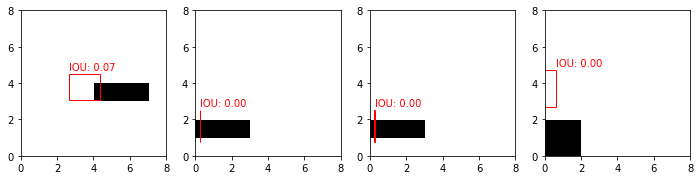

In [96]:

plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')


# mean IOU (overlap) entre bound boxes predito e original

In [97]:
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.04184047076555755